# **Assignment 2**

## Id numbers and names


1.   313326985 Shahar Shcheranski
2.   206172686 Sarit Hollander

##Imports

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 5.3 MB/s 


In [ ]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Lambda, Subtract, MaxPool2D
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import random
import itertools
import joblib
import time

In [ ]:
# tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )

# tf.config.list_physical_devices('GPU')

## **Data set - Labeled Faces in the Wild**

The "Labeled Faces in the Wild-a" image collection is a database of labeled, face images intended for studying Face Recognition in unconstrained images. 

### **Download the dataset**

In [ ]:
# The url provided in the work instructions
url = "https://drive.google.com/file/d/1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp/view?usp=sharing"

In [ ]:
# Download the dataset from the url
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1p1wjaqpTh_5RHfJu4vUh8JJCdKwYMHCp" -O LFW-a && rm -rf /tmp/cookies.txt
!unzip -q LFW-a && rm LFW-a

In [ ]:
DATAPATH = './lfw2/lfw2/'

### **Train and Test sets**

We used the training set and the test set attached to the instructions. 
In addition, we produce a validation set which will be 20% of the training set (and the rest will be the training set).

In [ ]:
# Download the train and test meta data
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
!wget http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt

--2022-05-17 19:50:17--  http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56579 (55K) [text/plain]
Saving to: ‘pairsDevTrain.txt’

pairsDevTrain.txt   100%[===================>]  55.25K  --.-KB/s    in 0.09s   

2022-05-17 19:50:17 (594 KB/s) - ‘pairsDevTrain.txt’ saved [56579/56579]

--2022-05-17 19:50:17--  http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26002 (25K) [text/plain]
Saving to: ‘pairsDevTest.txt’

pairsDevTest.txt    100%[===================>]  25.39K  --.-KB/s    in 0.05s   

2022-05-17 19:50:18 (545 KB/s) - ‘pairsDevTest.txt’ saved [26002/2

In [ ]:
# global seed
seed = 10
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
# Save image paths in data frame
def read_data(path):
  match_pairs = pd.DataFrame(columns=['Name1', 'Image1', 'Name2', 'Image2', 'Label'])
  mismatch_pairs= pd.DataFrame(columns=['Name1', 'Image1', 'Name2', 'Image2', 'Label'])
  with open(path) as f:
      for line in f:
          row = line.split()
          if len(row) == 3:
            data_to_append = {}
            row[1] = f'{DATAPATH}{row[0]}/{row[0]}_{str(row[1]).rjust(4, "0")}.jpg'
            row[2] = f'{DATAPATH}{row[0]}/{row[0]}_{str(row[2]).rjust(4, "0")}.jpg'
            for i in range(len(match_pairs.columns)):
              if i == 2:
                data_to_append[match_pairs.columns[i]] = row[0]
              elif i == 3:
                data_to_append[match_pairs.columns[i]] = row[2]
              elif i == 4:
                data_to_append[match_pairs.columns[i]] = 'same'
              else:
                data_to_append[match_pairs.columns[i]] = row[i]
            match_pairs = match_pairs.append(data_to_append, ignore_index = True)
          elif len(row) == 4:
            data_to_append = {}
            row[1] = f'{DATAPATH}{row[0]}/{row[0]}_{str(row[1]).rjust(4, "0")}.jpg'
            row[3] = f'{DATAPATH}{row[2]}/{row[2]}_{str(row[3]).rjust(4, "0")}.jpg'
            for i in range(len(mismatch_pairs.columns)):
              if i == 4:
                data_to_append[match_pairs.columns[i]] = 'different'
              else:
                data_to_append[mismatch_pairs.columns[i]] = row[i]
            mismatch_pairs = mismatch_pairs.append(data_to_append, ignore_index = True)
  return pd.concat([match_pairs, mismatch_pairs]).reset_index(drop=True)


In [ ]:
# Split the data into train, validation and test sets
# The validation set is 20% of training set
def split_train_validation_test():
  train_validation = read_data('./pairsDevTrain.txt')
  test = read_data('./pairsDevTest.txt')

  seed = 10
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)

  validation = train_validation.sample(frac = 0.2)
  train = train_validation.drop(validation.index)

  return train, validation, test

In [ ]:
def load_image(image_path):
    img = cv2.imread(image_path)/255
    img = (cv2.resize(img, (105, 105)))
    return img

In [ ]:
def load_X(meta_data):
  X1 = []
  X2 = []
  for index, row in meta_data.iterrows():
    image1 = load_image(row['Image1'])
    X1.append(image1)
    image2 = load_image(row['Image2'])
    X2.append(image2)
    

  return np.array([[x1, x2] for x1, x2 in zip(X1, X2)])

In [ ]:
def load_Y(meta_data):
  Y = pd.DataFrame(meta_data['Label'].copy())
  Y['Label'].replace({"same":1, "different":0}, inplace=True)

  return Y.to_numpy()

In [ ]:
def load_X_Y(train, validation, test):
  X_train = load_X(train)
  X_val = load_X(validation)
  X_test = load_X(test)
  Y_train = load_Y(train)
  Y_val = load_Y(validation)
  Y_test = load_Y(test)

    
  return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [ ]:
train, validation, test = split_train_validation_test()
X_train, Y_train, X_val, Y_val, X_test, Y_test = load_X_Y(train, validation, test)

### **Analysis of the dataset**

size, number of examples – in total and per class – for the train and test sets, etc.

The dataset contains a total of 3200 samples.
Where each smaple contains two images, and each sample is labeled as 'same' or 'different'.
*   There are 2200 samples in the training set, 1100 of them are labeled as 'same' and 1100 of them are labeled as 'different'. 
*   There are 1000 samples in the test set, 500 of which are labeled as 'same' and 500 of which are labeled as 'different'.

We splitted the train set into train and validation sets (the validation set contains 20% if the train set).


In [ ]:
peoples = os.listdir(DATAPATH)
peoples_images = [len(os.listdir(f'{DATAPATH}/{people}')) for people in peoples]


Total:

In [ ]:
print("The dataset contains images of " + str(len(peoples)) + " peoples")
print("The dataset contains a total of " + str(np.sum(peoples_images)) + " images")
print("Each pesron has an average " + str(np.round(np.mean(peoples_images),3)) + " +- " + str(np.round(np.std(peoples_images),3)) + " images")

The dataset contains images of 5749 peoples
The dataset contains a total of 13233 images
Each pesron has an average 2.302 +- 9.016 images


Training set:

The training set contains 1760 examples
The training set contains 876 match examples - class 'same'
The training set contains 884 mismatch examples - class 'different'


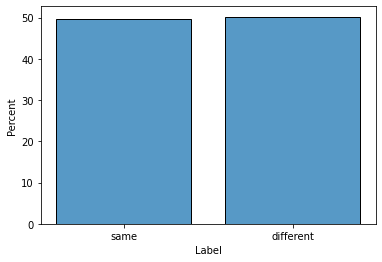

In [ ]:
print("The training set contains " + str(train.shape[0]) + " examples")
print("The training set contains " + str(train[train['Label'] == 'same'].count()[0]) + " match examples - class 'same'")
print("The training set contains " + str(train[train['Label'] == 'different'].count()[0]) + " mismatch examples - class 'different'")
sns.histplot(data=train, x="Label", stat="percent", shrink=.8)

Validation set:

The validation set contains 440 examples
The validation set contains 224 match examples - class 'same'
The validation set contains 216 mismatch examples - class 'different'


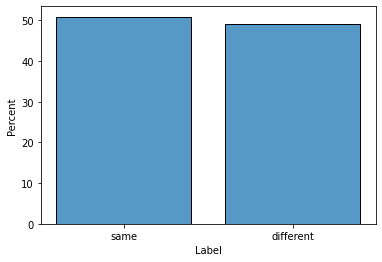

In [ ]:
print("The validation set contains " + str(validation.shape[0]) + " examples")
print("The validation set contains " + str(validation[validation['Label'] == 'same'].count()[0]) + " match examples - class 'same'")
print("The validation set contains " + str(validation[validation['Label'] == 'different'].count()[0]) + " mismatch examples - class 'different'")
sns.histplot(data=validation, x="Label", stat="percent", shrink=.8)

Test set:

The test set contains 1000 examples
The test set contains 500 match examples - class 'same'
The test set contains 500 mismatch examples - class 'different'


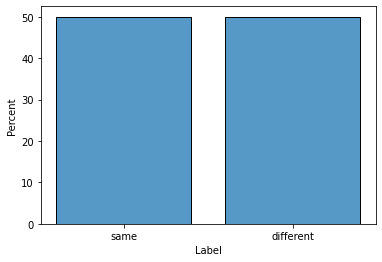

In [ ]:
print("The test set contains " + str(test.shape[0]) + " examples")
print("The test set contains " + str(test[test['Label'] == 'same'].count()[0]) + " match examples - class 'same'")
print("The test set contains " + str(test[test['Label'] == 'different'].count()[0]) + " mismatch examples - class 'different'")
sns.histplot(data=test, x="Label", stat="percent", shrink=.8)

In [ ]:
sample_same1 = train[train['Label'] == 'same'].sample()
sample_same2 = train[train['Label'] == 'same'].sample()
sample_different1 = train[train['Label'] == 'different'].sample()
sample_different2 = train[train['Label'] == 'different'].sample()

Examples of 'same' images:

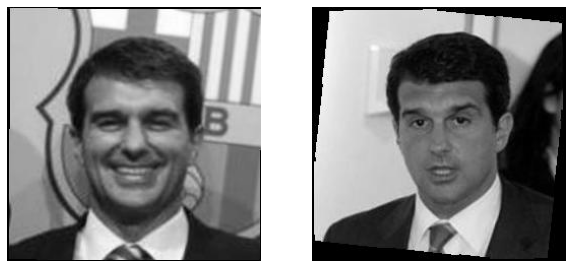

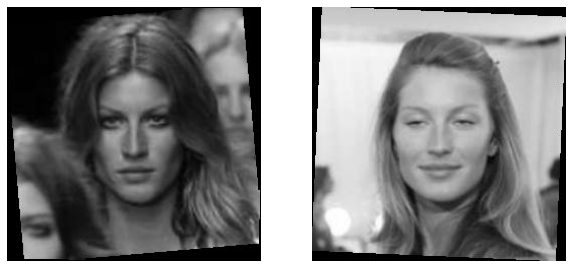

In [ ]:
img11 = cv2.imread(sample_same1['Image1'].values[0])
img21 = cv2.imread(sample_same1['Image2'].values[0])
img12 = cv2.imread(sample_same2['Image1'].values[0])
img22 = cv2.imread(sample_same2['Image2'].values[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for i, img in enumerate([img11, img21]):
  ax[i].axis('off')
  ax[i].imshow(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for i, img in enumerate([img12, img22]):
  ax[i].axis('off')
  ax[i].imshow(img)


Examples of 'different' images:

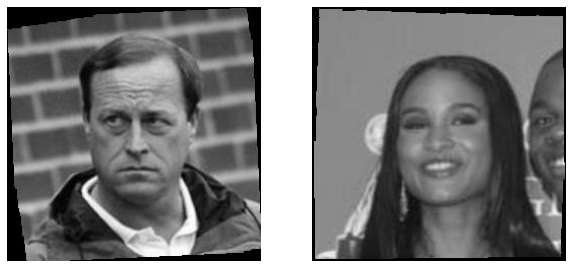

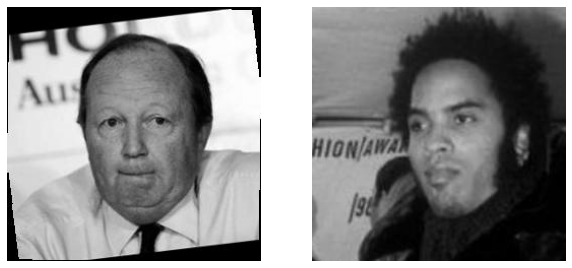

In [ ]:
img11 = cv2.imread(sample_different1['Image1'].values[0])
img21 = cv2.imread(sample_different1['Image2'].values[0])
img12 = cv2.imread(sample_different2['Image1'].values[0])
img22 = cv2.imread(sample_different2['Image2'].values[0])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for i, img in enumerate([img11, img21]):
  ax[i].axis('off')
  ax[i].imshow(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
for i, img in enumerate([img12, img22]):
  ax[i].axis('off')
  ax[i].imshow(img)

## **Siamese network**

### **Our architecture**:

We reconstructed the architecture from the paper:

We first created a Siamese network consist of two Convolutional Neural Networks that are joined towards the end. The goal of this part is to constracting the feature vectors.

Each CNN has 4 conventional layers and 1 fully connected layer. Then we combined both networks to a single output by a distance layer. In this part we compare between the two vectors.

- There are 2 input layers of 105x105x3 that represent 2 images to compare.

- For all CNN layers (except the last layer) we used 'l2' **kernel regularizer** with regularization factor of $2e-4$ and perform batch normalization.

- In the last layer (fully connected) we used 'l2' **kernel regularizer** with regularization factor of $2e-3$.

- Then, we connected both networks with one more layer - the L1 distance vector, on which we performed a **dropout** of 0.3, wihch created the Siamese network, using "**sigmoid**" activation function.

**Parameters Initialization:**

* We initialized the weights of the **kernel initializer** in all layers to a normal distribution with mean of 0 and standard deviation of $10^{-2}$, as discribed in the paper.
* We initialized the **bias** with mean of 0.5 and standard deviation of $10^{-2}$, as discribed in the paper.
We performed it on all layers except the first layer, since no bias in the first layer might be more beneficial when the layer is very large and the data is distributed uniformly as in our case.

**Early Stopping:**

We used early stopping that will stop the training when the monitor metric of validation loss stops to improve with a **delta** (minimum change) of 0.01 and **patience** (number of epochs without improvments) of 6.

We also used **batch normalization** on each layer exept the fully connected one.

**Loss Function:**

binary_crossentropy - in the paper they also used the loss function of cross-entropy since the L1 distance between the feature vectors combined with the sigmoid activation which maps onto the interval of [0, 1], and makes it very natural choise.

In [ ]:
# global seed
seed = 10
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
def kernel_initializer(shape, dtype=None):
  """
  Initializing weights for the siamese model. useing the keras random_normal function.
  returns a tensor with normal distribution of weights
  """
  return K.random_normal(shape, mean=0.0, stddev=0.01, dtype=dtype, seed=seed)


def bias_initializer(shape, dtype=None):
  """
  Initializing biases for the siamese model. useing the keras random_normal function.
  return a tensor with normal distribution of weights
  """
  return K.random_normal(shape, mean=0.5, stddev=0.01, seed=seed)

In [ ]:
def siamese_model(input_shape):
    """
    Building the CNN network that will use in the siamese model according to the architecture used in the paper.
    """
    model = Sequential()

    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape,kernel_initializer=kernel_initializer,kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), activation='relu',kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation='relu',kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), activation='relu',kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',kernel_initializer=kernel_initializer,bias_initializer=bias_initializer,kernel_regularizer=l2(2e-3)))

    return model

**Number of layers, dimenstions and filters, as well as total parameters:**

In [ ]:
input_shape = X_train[0].shape[1:]
siamese_model(input_shape).summary()
print("input size: " + str(input_shape))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 128)      512       
 hNormalization)                                                 
                                                        

In [ ]:
def get_siamese_model(input_shape, parameters):
    """
    Building the siamese model using the CNN network we built
    """
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # get the cnn network 
    model = siamese_model(input_shape)

    encoded_l = model(left_input)
    encoded_r = model(right_input)

    # Combining the 2 CNN's with a new layer
    L1_layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_siamese_distance = L1_layer([encoded_l, encoded_r])
    L1_siamese_distance = Dropout(parameters['dropout'])(L1_siamese_distance)

    output = Dense(1, activation='sigmoid',bias_initializer=bias_initializer)(L1_siamese_distance)

    my_model = Model(inputs=[left_input, right_input], outputs=output)
    my_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=parameters['learning_rate']), metrics=['accuracy'])

    return my_model

In [ ]:
def fit_model(build_model, training_set, validation_set, early_stop, delta, patience, use_cache=False, parameters=None):
    """
    Train the model using a training set and validation set.
    Using early stopping to monitor the validation loss with delta (minimum change) of 0.01 and patience (number of epochs without improvments) of 6
    """ 

    # Here we save the model and the model history to a faster runtime while testing multiple parameters   
    os.makedirs('./my_models', exist_ok=True)
    model_params = ''
    if parameters is not None:
        model_params = '_'.join(str(key) + '_' + str(value) for key, value in parameters.items())

    model_name = build_model.__name__[4:] + '_' + model_params
    model_history_path = './my_models/' + model_name + '_history.sav'
    model_path = './my_models/' + model_name + '.h5'

    # if use cache is true then we check if the model is exist and use it instead of fitting again
    if use_cache and os.path.exists(model_history_path):
        model_history = joblib.load(model_history_path)
        print(model_path, "loaded from cache")
    else:
      print(model_path, "doesn't exist, building")
      callbacks = []
      if early_stop:
          early_stopping = EarlyStopping(monitor='val_loss', min_delta=delta, patience=patience, mode='auto', verbose=1)
          callbacks.append(early_stopping)
      
      checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='auto')
      callbacks.append(checkpoint)

      # Transpose performed to fit the data to the input
      x_train, y_train = training_set
      x_val, y_val = validation_set
      transposed_x_train = x_train.transpose((1,0,2,3,4))
      transposed_x_val = x_val.transpose((1,0,2,3,4))
      input_shape = x_train[0].shape[1:]
  
      model = build_model(input_shape, parameters=parameters)
      model_history = model.fit([transposed_x_train[0], transposed_x_train[1]], y_train, batch_size=parameters['batch_size'], epochs=parameters['epochs'],
                validation_data=([transposed_x_val[0], transposed_x_val[1]], y_val),
                callbacks=callbacks,
                verbose=1)
      model_history = model_history.history

      joblib.dump(model_history, model_history_path)
      model.save(model_path)

      print("Saved model: " + model_name)
    
    model = tf.keras.models.load_model(model_path, custom_objects={'bias_initializer': bias_initializer, 'kernel_initializer': kernel_initializer, 'tf': tf})
    

    return model, model_history

##**Analysis of our architecture’s performance**

**Convergence times, final loss and accuracy on the test set and holdout set:**

In [ ]:
# Global parameters
EARLY_STOP = True
DELTA = 0.01
PATIENCE = 6

In [ ]:
def run(build_model, parameters):
    """
    Get the model to fit and its parameters and fit it.
    Measure the fitting time.
    """
    start_time = time.time()
    my_siamese_model, my_siamese_history = fit_model(build_model, (X_train, Y_train),(X_val, Y_val), early_stop=EARLY_STOP, delta=DELTA, patience=PATIENCE, use_cache=False, parameters=parameters)
    end_time = time.time()
    total_time = end_time - start_time

    return my_siamese_model, my_siamese_history, total_time


def evaluate(trained_model, x_set, y_set):
    """
    Returns the model prediction statistics (loss and accuracy) on the data
    """
    x = x_set.transpose((1, 0, 2, 3, 4))
    results = trained_model.evaluate([x[0], x[1]], y_set)

    return results

We decided to use a validation set since the data is not very big so its better to use it. We divide it to 80% training and 20% valitation which performed well.
After we performed a hyperparameters search we found our best parameters to be:
- learning rate: 0.00005
- batch size: 32
- epochs: 30
- dropout: 0.3

In [ ]:
# Use the best parameters we found in experiments to fit and evaluate the model 
best_parameters = {'learning_rate': 0.00005, 'dropout': 0.3, 'epochs': 30, 'batch_size': 32}
my_siamese_model, my_siamese_history, total_time = run(get_siamese_model, best_parameters)

seed = 10
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

train = evaluate(my_siamese_model, X_train, Y_train)
validation = evaluate(my_siamese_model, X_val, Y_val)
test = evaluate(my_siamese_model, X_test, Y_test)

./my_models/siamese_model_learning_rate_5e-05_dropout_0.3_epochs_30_batch_size_32.h5 doesn't exist, building
Epoch 1/30
55/55 [==============================] - 24s 388ms/step - loss: 7.9500 - accuracy: 0.6341 - val_loss: 7.7507 - val_accuracy: 0.5091
Epoch 2/30
55/55 [==============================] - 16s 300ms/step - loss: 7.1596 - accuracy: 0.8881 - val_loss: 7.2088 - val_accuracy: 0.5182
Epoch 3/30
55/55 [==============================] - 17s 305ms/step - loss: 6.5028 - accuracy: 0.9773 - val_loss: 6.6711 - val_accuracy: 0.6227
Epoch 4/30
55/55 [==============================] - 16s 299ms/step - loss: 5.9227 - accuracy: 0.9955 - val_loss: 6.1288 - val_accuracy: 0.7136
Epoch 5/30
55/55 [==============================] - 16s 299ms/step - loss: 5.4031 - accuracy: 1.0000 - val_loss: 5.6210 - val_accuracy: 0.7386
Epoch 6/30
55/55 [==============================] - 16s 299ms/step - loss: 4.9264 - accuracy: 1.0000 - val_loss: 5.1528 - val_accuracy: 0.7477
Epoch 7/30
55/55 [===============

Here we see the results of the convergence time, loss and accuracy of our Siamese model on the train, validation and test

In [ ]:
print("Model fitting time: " + str(total_time) + " seconds")
print("Results:")
print("Train -> loss: " + str(train[0]) + ", accuracy percentage: " + str(train[1] * 100) + "%")
print("Validation -> loss: " + str(validation[0]) + ", accuracy percentage: " + str(validation[1] * 100) + "%")
print("Test -> loss: " + str(test[0]) + ", accuracy percentage: " + str(test[1] * 100) + "%")

Model fitting time: 510.3927946090698 seconds
Results:
Train -> loss: 0.2668054401874542, accuracy percentage: 100.0%
Validation -> loss: 0.7450321316719055, accuracy percentage: 79.09091114997864%
Test -> loss: 0.8486946821212769, accuracy percentage: 70.80000042915344%


**Graphs describing the loss on the training set throughout the training process:**

In [ ]:
def plot_loss(model_history):
    """
    Plotting the loss on the train and validation sets
    """
    plt.plot(model_history['loss'])
    plt.plot(model_history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

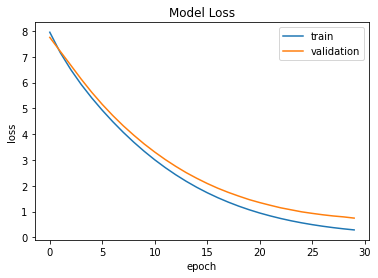

In [ ]:
plot_loss(my_siamese_history)

We can see the loss function is a reducing for each epoch, and the validation set predicted the loss well

In [ ]:
def plot_accuracy(model_history):
    """
    Plotting the accuracy on the train and validation sets
    """
    plt.plot(model_history['accuracy'])
    plt.plot(model_history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

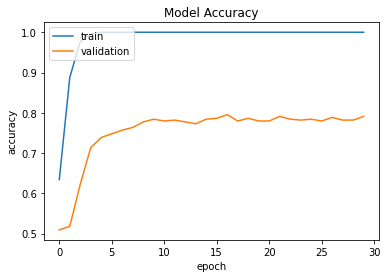

In [ ]:
plot_accuracy(my_siamese_history)

This figure shows the the accuracy of the training set and validation for each epoch. We can see that the accuracy of the validation set stop improving significantlly in about 10 epochs, but as we saw in the model loss function plot, it's loss was continued to decrease.

**Performance when experimenting with the various parameters:**

In [ ]:
def clear_session(model):
    """
    Clearing the session to removes all the nodes left over from previous models,
    freeing memory and preventing slowdown during hyperparameter search
    """
    del model
    tf.keras.backend.clear_session()

In [ ]:
def find_best_params():
    """
    Performing hyperparameters search to find the best parameters for the model  
    """
    learning_rate = [0.001, 0.00001, 0.00005]
    dropout = [0.3, 0.4]
    epochs = [10, 20, 30]
    batch_size = [32, 64]
    combinations_list = list(itertools.product(learning_rate, dropout, epochs, batch_size))
    
    params_names = ['learning_rate', 'dropout', 'epochs', 'batch_size']
    
    best_parameters = {}
    best_accuracy = 0
    
    for combination in combinations_list:
        seed = 10
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        
        # Creating different combiniation of parameters to fit the model
        parameters = {params_names[i]: combination[i] for i in range(len(combination))}
        siamese_model, _ = fit_model(get_siamese_model, (X_train, Y_train), (X_val, Y_val),
                                  early_stop=EARLY_STOP, delta=DELTA, patience=PATIENCE, use_cache=True, parameters=parameters)
        transposed_x_val = X_val.transpose((1,0,2,3,4))
        loss, accuracy = siamese_model.evaluate([transposed_x_val[0], transposed_x_val[1]], Y_val, verbose=0)
        clear_session(siamese_model)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_parameters = parameters
        print("parameters: " + str(parameters) + ", loss: " + str(loss) + ", accuracy: " + str(accuracy*100) + "%")
    
    return best_parameters

In [ ]:
best_parameters = find_best_params()
print("Best parameters: " + str(best_parameters))

./my_models/siamese_model_learning_rate_0.001_dropout_0.3_epochs_10_batch_size_32.h5 doesn't exist, building
Epoch 1/10
55/55 [==============================] - 20s 335ms/step - loss: 6.2769 - accuracy: 0.5506 - val_loss: 3.9918 - val_accuracy: 0.5227
Epoch 2/10
55/55 [==============================] - 17s 302ms/step - loss: 2.9081 - accuracy: 0.5818 - val_loss: 2.2018 - val_accuracy: 0.5295
Epoch 3/10
55/55 [==============================] - 16s 300ms/step - loss: 1.8635 - accuracy: 0.6045 - val_loss: 1.6963 - val_accuracy: 0.5545
Epoch 4/10
55/55 [==============================] - 17s 304ms/step - loss: 1.4640 - accuracy: 0.6335 - val_loss: 1.4179 - val_accuracy: 0.5795
Epoch 5/10
55/55 [==============================] - 17s 305ms/step - loss: 1.3564 - accuracy: 0.6335 - val_loss: 1.3143 - val_accuracy: 0.6523
Epoch 6/10
55/55 [==============================] - 15s 274ms/step - loss: 1.3445 - accuracy: 0.6472 - val_loss: 1.3965 - val_accuracy: 0.6182
Epoch 7/10
55/55 [===============


**Best parameters:**

*   learning_rate - 0.00005
*   dropout - 0.3
*   epochs - 30
*   batch_size - 32



**Examples of accurate and misclassifications:**

In [ ]:
def predict(trained_model, X):
    """
    Getting trained model an get it's predictions
    """
    x = X.transpose((1, 0, 2, 3, 4))
    x_test = [x[0], x[1]]
    predictions = trained_model.predict(x_test)

    return predictions.reshape(-1)


def generate_examples(idxs_to_example, predictions):
    """
    Show examples of images the model successfully classified and images that was missed classified
    """


    for idx in idxs_to_example:
        color = 'lightgreen' if Y_test[idx] == np.around(predictions)[idx] else 'tomato'
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,6), facecolor=color)

        fig.tight_layout()

        # Label of 'same'
        if Y_test[idx] == 1:
            t = f'model predicted same in: {predictions[idx]*100:.2f}%'
        # Label of 'different'
        if Y_test[idx] == 0:
            t = f'model predicted different in: {100 - predictions[idx] * 100:.2f}%'
        # Check if the model classification was correct
        if Y_test[idx] == np.round(predictions[idx]):
            fig.suptitle('Correct! ' + t, fontsize=12)
        else:
            fig.suptitle('Wrong! ' + t, fontsize=12)


        for i, axis in enumerate(ax):
            ax[i].axis('off')
            ax[i].imshow(X_test.transpose((1, 0, 2, 3, 4))[i][idx])

Model performance on the 'same' images:

In [ ]:
model_predictions = predict(my_siamese_model, X_test)

num_of_same_imgs = Y_test.shape[0]//2
tpr = (np.around(model_predictions)[:num_of_same_imgs].sum() / num_of_same_imgs) * 100

print("The model predicted  successfully " + str(tpr) + "% out of all the 'same' subset in the test set")

The model predicted  successfully 75.6% out of all the 'same' subset in the test set


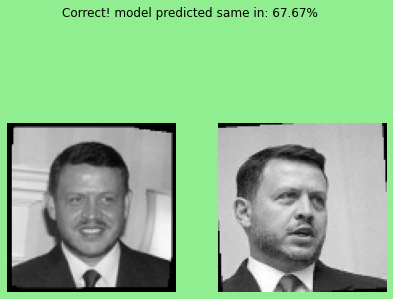

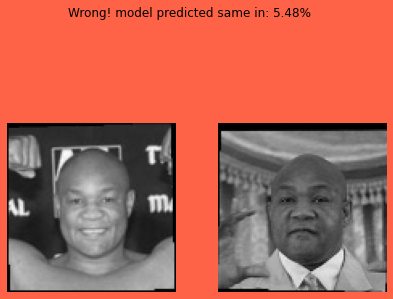

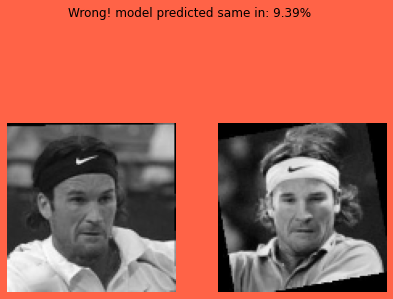

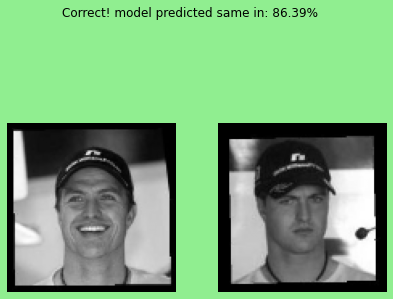

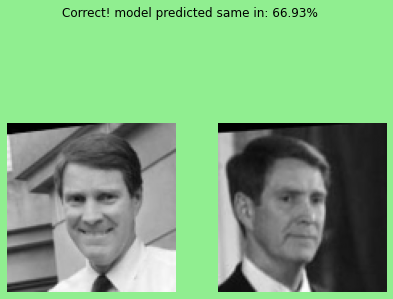

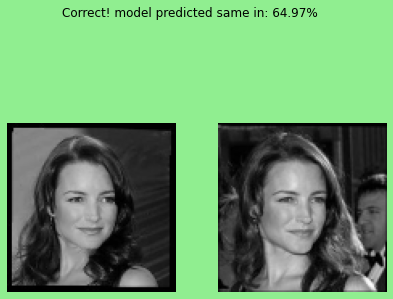

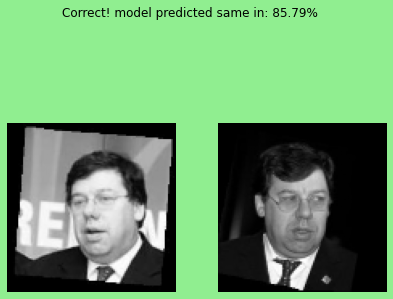

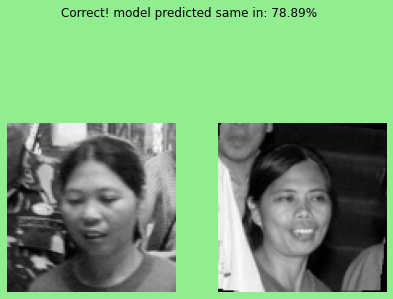

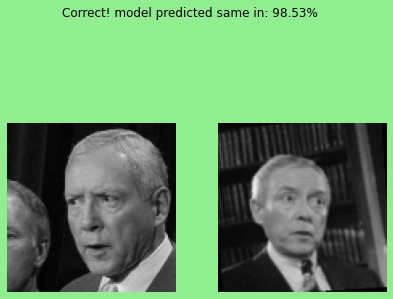

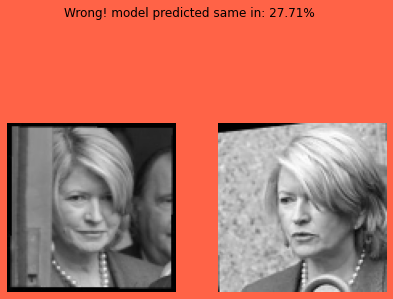

In [ ]:
# Generate random index list for the examples
index_list = random.sample(list(range(num_of_same_imgs)), 10)
generate_examples(index_list, model_predictions)

We can see that our model able to predict well the images from the 'same' subset.
There are only 3 pairs which the model did not identify as 'same':


1.   In the image on the left, the man raises his hands.
2.   The person puts a different colored headband in each image.
3.   In the left image there is a door that hides some of the face of the person.



Model performance on the 'different' images:

In [ ]:
tnr = ((num_of_same_imgs - np.around(model_predictions)[num_of_same_imgs:].sum()) / num_of_same_imgs) * 100

print("The model predicted  successfully " + str(tnr) + "% out of all the 'different' subset in the test set")

The model predicted  successfully 66.0% out of all the 'different' subset in the test set


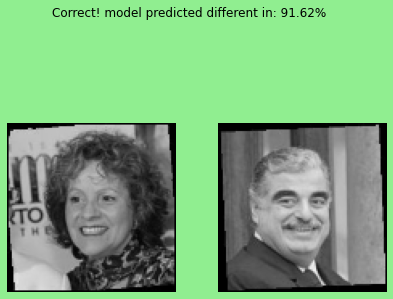

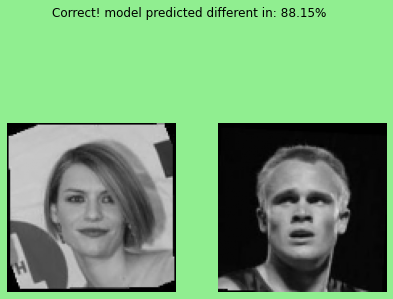

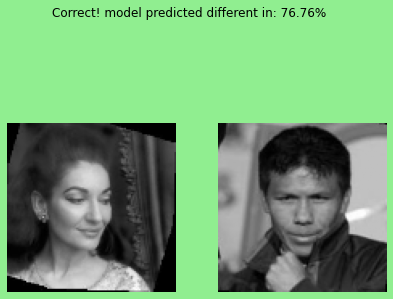

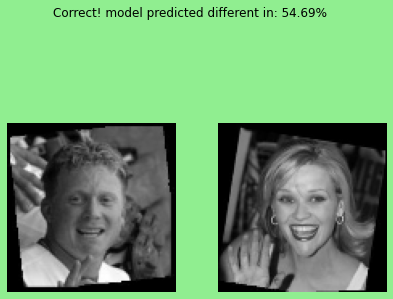

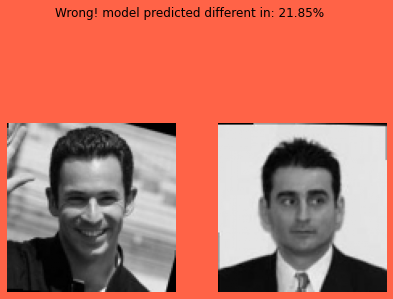

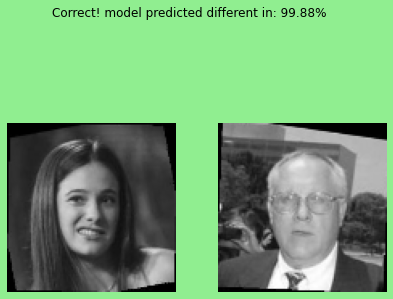

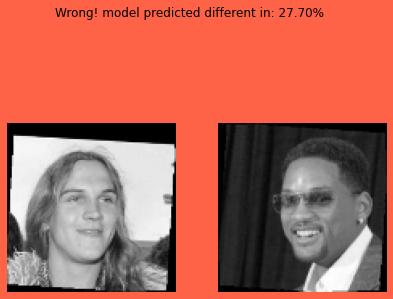

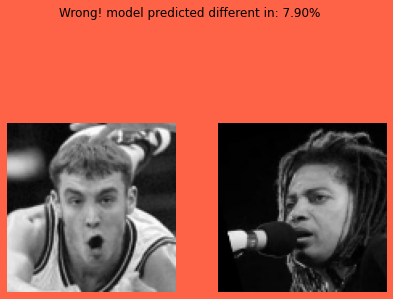

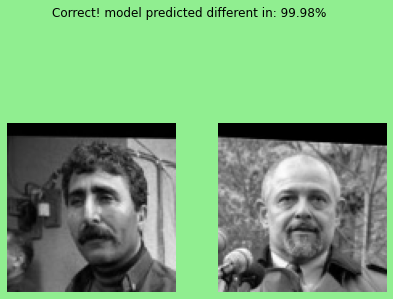

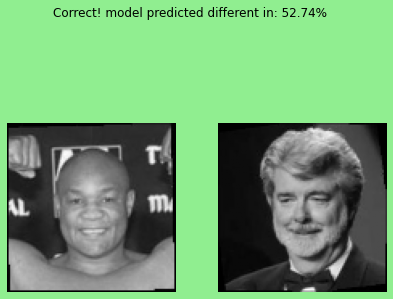

In [ ]:
# Generate random index list for the examples
index_list = random.sample(list(range(num_of_same_imgs,Y_test.shape[0])), 10)
generate_examples(index_list, model_predictions)

We can see that our model was less successful to predict the images from the 'different' subset. 
The model was particularly successful in the simplest cases, when there was one image of a man and one image of a woman.
Another case where the model succeeded is when the in one picture a man has hair and in the other picture the man is bald.
